In [1]:
using MGVI

In [2]:
using Distributions
using Random
using Optim

In [3]:
using Plots

In [4]:
using FFTW

In [5]:
import ForwardDiff

In [6]:
Random.seed!(84612);

In [7]:
coal_mine_disaster_data = [4, 6, 4, 0, 0, 5, 4, 2, 2, 5, 3, 3, 3, 0, 3, 5, 3, 3, 6, 6, 3, 3,
       0, 4, 4, 4, 4, 5, 2, 4, 2, 4, 3, 2, 2, 5, 1, 3, 3, 0, 2, 1, 1, 1,
       2, 2, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 1, 3, 1, 2, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 2, 3, 2, 1, 1, 2, 1, 1, 1,
       1, 2, 5, 1, 0, 0, 0, 2, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1];

In [8]:
VERBOSE = false;

In [9]:
DATA_DIM = 111;

In [10]:
DATA_XLIM = [1851., 1962.];

In [11]:
GP_GRAIN_FACTOR = 1;
GP_OFFSET = 80;

In [12]:
function produce_bins()
    data_binsize = (DATA_XLIM[2] - DATA_XLIM[1])/DATA_DIM
    gp_binsize = data_binsize/GP_GRAIN_FACTOR
    gp_dim = Integer(((DATA_XLIM[2] - DATA_XLIM[1]) + 2*GP_OFFSET) ÷ gp_binsize)
    gp_left_bin_offset = gp_right_bin_offset = (gp_dim - DATA_DIM) ÷ 2
    if (2*gp_left_bin_offset + DATA_DIM) % 2 == 1
        gp_left_bin_offset += 1
    end
    gp_left_xlim = DATA_XLIM[1] - gp_left_bin_offset*gp_binsize
    gp_right_xlim = DATA_XLIM[2] + gp_right_bin_offset*gp_binsize
    gp_left_xs = collect(gp_left_xlim + gp_binsize/2:gp_binsize:DATA_XLIM[1])
    gp_right_xs = collect(DATA_XLIM[2] + gp_binsize/2:gp_binsize:gp_right_xlim)
    gp_data_xs = collect(DATA_XLIM[1] + gp_binsize/2:gp_binsize:DATA_XLIM[2])
    gp_xs = [gp_left_xs; gp_data_xs; gp_right_xs]
    data_idxs = collect(gp_left_bin_offset+1:GP_GRAIN_FACTOR:gp_left_bin_offset+DATA_DIM)
    gp_xs, gp_binsize, data_idxs
end;

In [13]:
_GP_XS, _GP_BINSIZE, _DATA_IDXS = produce_bins();
_GP_DIM = length(_GP_XS);

In [14]:
function assemble_paridx(;kwargs...)
    pos = 0
    res = []
    for (k, v) in kwargs
        new_start, new_stop = v.start+pos, v.stop+pos
        push!(res, (k, (v.start+pos):(v.stop+pos)))
        pos = new_stop
    end
    (;res...)
end;

In [15]:
PARIDX = assemble_paridx(gp_hyper=1:2, gp_latent=1:_GP_DIM);

In [16]:
starting_point = randn(last(PARIDX).stop);

In [17]:
k = collect(0:(_GP_DIM)÷2 -1);

In [18]:
# squared exp model. sqrt of the covariance matrix in the Fourier space
function kernel_model(p) 
    kernel_A_c, kernel_l_c = p[PARIDX.gp_hyper]
    kernel_A = 50*exp(kernel_A_c*0.6)
    kernel_l = 0.028*exp(kernel_l_c/20)
    positive_modes = kernel_A .* sqrt(2 * π * kernel_l) .* exp.( -π^2 .* k.^2 .* kernel_l^2)
    negative_modes = positive_modes[end:-1:1]
    [positive_modes; negative_modes]
end;

if VERBOSE
    kernel_model(starting_point)
end

In [19]:
ht = FFTW.plan_r2r(zeros(_GP_DIM), FFTW.DHT);

In [20]:
function gp_sample(p)
    flat_gp = kernel_model(p) .* p[PARIDX.gp_latent]
    (ht * flat_gp) ./ _GP_DIM
end;

if VERBOSE
    gp_sample(starting_point)
end

In [21]:
function gp_sample(dp::Vector{ForwardDiff.Dual{T, V, N}}) where {T,V,N}
    flat_gp_duals = kernel_model(dp) .* dp[PARIDX.gp_latent]
    val_res = ht*ForwardDiff.value.(flat_gp_duals) ./ _GP_DIM
    psize = size(ForwardDiff.partials(flat_gp_duals[1]), 1)
    ps = x -> ForwardDiff.partials.(flat_gp_duals, x)
    val_ps = map((x -> ht*ps(x) ./ _GP_DIM), 1:psize)
    ForwardDiff.Dual{T}.(val_res, val_ps...)
end;

In [22]:
function poisson_gp_link(fs)
    exp.(fs)
end;

if VERBOSE
    poisson_gp_link(gp_sample(starting_point)) .* _GP_BINSIZE
end

In [23]:
function agg_lambdas(lambdas)
    [sum(lambdas[i:i+GP_GRAIN_FACTOR-1])*_GP_BINSIZE for i in _DATA_IDXS]
end;

if VERBOSE
    agg_lambdas(poisson_gp_link(gp_sample(starting_point)))
end

In [24]:
function model(params)
    fs = gp_sample(params)
    fine_lambdas = poisson_gp_link(fs)
    lambdas = agg_lambdas(fine_lambdas)
    Product(Poisson.(lambdas))
end;

In [25]:
data = coal_mine_disaster_data;

In [26]:
function _mean(p)
    agg_lambdas(poisson_gp_link(gp_sample(p)))
end;

In [27]:
function plot_mean(p, label="mean")
    plot!(_GP_XS[_DATA_IDXS .+ (GP_GRAIN_FACTOR ÷ 2)], _mean(p), label=label, linewidth=2)
end;

In [28]:
function plot_prior_samples(num_samples)
    for _ in 1:num_samples
        p = randn(last(PARIDX).stop)
        plot_mean(p, nothing)
    end
end;

In [29]:
function plot_data()
    scatter!(_GP_XS[_DATA_IDXS .+ (GP_GRAIN_FACTOR ÷ 2)], data, la=0, markersize=2., markerstrokewidth=0, label="data")
    smooth_step = 4
    smooth_xs = _GP_XS[_DATA_IDXS .+ (GP_GRAIN_FACTOR ÷ 2)][(smooth_step+1):(end-smooth_step)]
    smooth_data = [sum(data[i-smooth_step:i+smooth_step])/(2*smooth_step+1) for i in (smooth_step+1):(size(data, 1)-smooth_step)]
    plot!(smooth_xs, smooth_data, linewidth=2, linealpha=1, ls=:dash, label="smooth data")
end

plot_data (generic function with 1 method)

In [30]:
function plot_mgvi_samples(params)
    for sample in eachcol(params.samples)
        if any(isnan.(sample))
            print("nan found in samples", "\n")
            continue
        end
        plot!(_GP_XS[_DATA_IDXS .+ (GP_GRAIN_FACTOR ÷ 2)], _mean(Vector(sample)), linealpha=0.5, linewidth=1, label=nothing)
    end
    plot!()
end;

In [31]:
function plot_full_gp(p)
    gp = poisson_gp_link(gp_sample(p))
    left_gp = [sum(gp[i:i+GP_GRAIN_FACTOR-1])*_GP_BINSIZE for i in 1:GP_GRAIN_FACTOR:(_DATA_IDXS[1]-1)]
    left_xs = _GP_XS[1 + (GP_GRAIN_FACTOR ÷ 2):GP_GRAIN_FACTOR:(_DATA_IDXS[1]-1)]
    right_gp = [sum(gp[i:i+GP_GRAIN_FACTOR-1])*_GP_BINSIZE for i in (_DATA_IDXS[end]+1):GP_GRAIN_FACTOR:size(gp, 1)]
    right_xs = _GP_XS[(_DATA_IDXS[end]+1) + (GP_GRAIN_FACTOR ÷ 2):GP_GRAIN_FACTOR:size(gp, 1)]
    middle = agg_lambdas(gp)
    plot!(_GP_XS[1:GP_GRAIN_FACTOR:size(gp, 1)], [left_gp; middle; right_gp], label="full gp")
end

plot_full_gp (generic function with 1 method)

### Prior samples

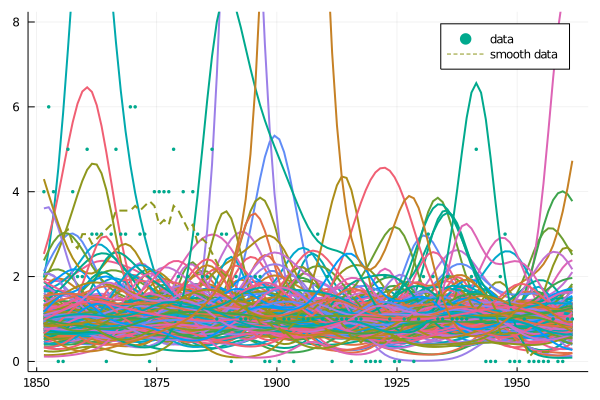

In [32]:
plot()
plot_prior_samples(200)
plot_data()
plot!(ylim=[0, 8])

### Fitting MGVI

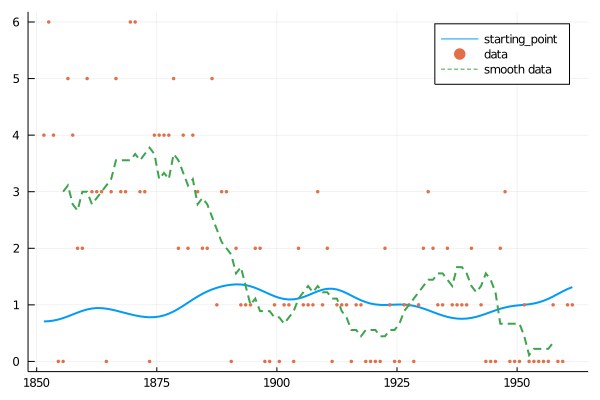

In [33]:
plot()
plot_mean(starting_point, "starting_point")
plot_data()

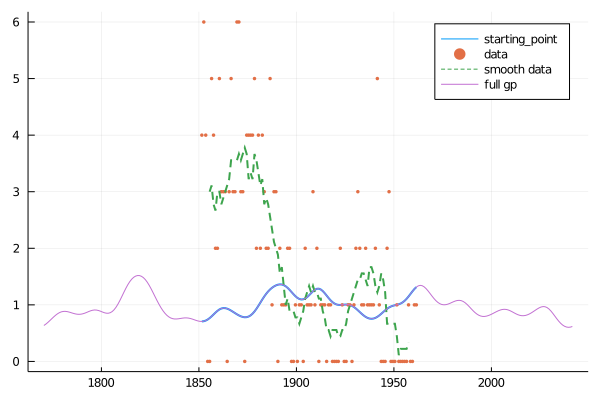

In [34]:
plot()
plot_mean(starting_point, "starting_point")
plot_data()
plot_full_gp(starting_point)

In [35]:
first_iteration = mgvi_kl_optimize_step(Random.GLOBAL_RNG,
                                        model, data,
                                        starting_point;
                                        num_residuals=3,
                                        jacobian_func=FwdRevADJacobianFunc,
                                        residual_sampler=ImplicitResidualSampler,
                                        optim_options=Optim.Options(iterations=1, show_trace=VERBOSE),
                                        residual_sampler_options=(;cg_params=(;abstol=1E-2,verbose=VERBOSE)));

if VERBOSE
    display(first_iteration)
end

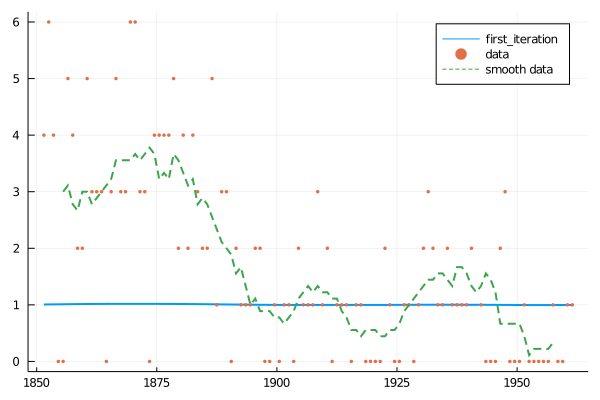

In [36]:
plot()
plot_mean(first_iteration.result, "first_iteration")
plot_data()

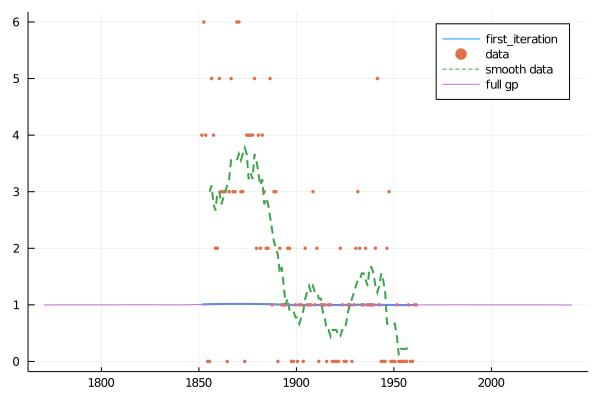

In [37]:
plot()
plot_mean(first_iteration.result, "first_iteration")
plot_data()
plot_full_gp(first_iteration.result)

In [38]:
function compute_avg_likelihood(model, samples, data)
    tot = 0
    for sample in eachcol(samples)
        tot += -logpdf(model(sample), data) + sample'*sample/2
    end
    tot/size(samples, 2)
end;

In [39]:
next_iteration = first_iteration;
avg_likelihood_series = [];
push!(avg_likelihood_series, compute_avg_likelihood(model, next_iteration.samples, data));

In [40]:
function show_avg_likelihood(series)
    scatter!(1:size(series, 1), series)
end;

In [41]:
for i in 1:20
    tmp_iteration = mgvi_kl_optimize_step(Random.GLOBAL_RNG,
                                          model, data,
                                          next_iteration.result;
                                          num_residuals=5,
                                          jacobian_func=FwdRevADJacobianFunc,
                                          residual_sampler=ImplicitResidualSampler,
                                          optim_options=Optim.Options(iterations=1, show_trace=VERBOSE),
                                          residual_sampler_options=(;cg_params=(;abstol=1E-2,verbose=VERBOSE)))
    next_iteration = tmp_iteration
    push!(avg_likelihood_series, compute_avg_likelihood(model, next_iteration.samples, data))
end;

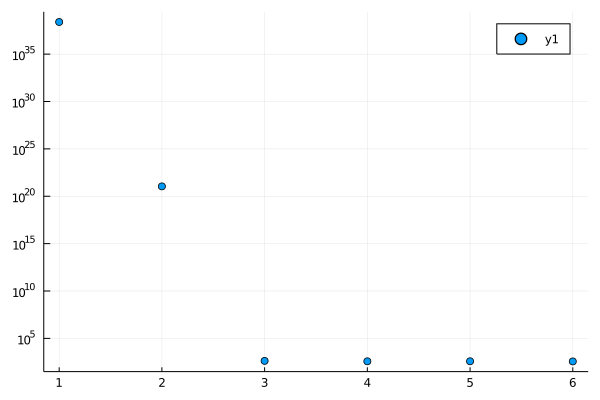

In [42]:
plot(yscale=:log)
show_avg_likelihood(avg_likelihood_series[1:6])

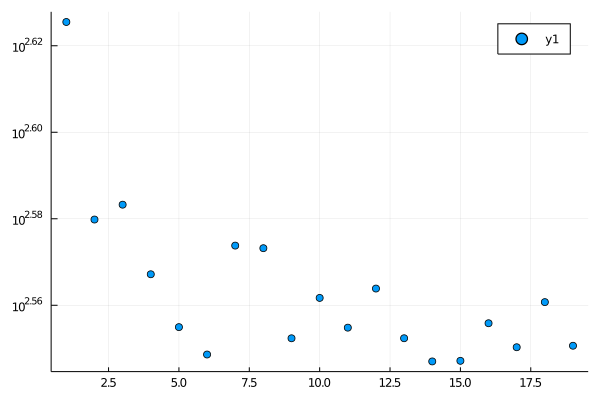

In [43]:
plot(yscale=:log)
show_avg_likelihood(avg_likelihood_series[3:end])

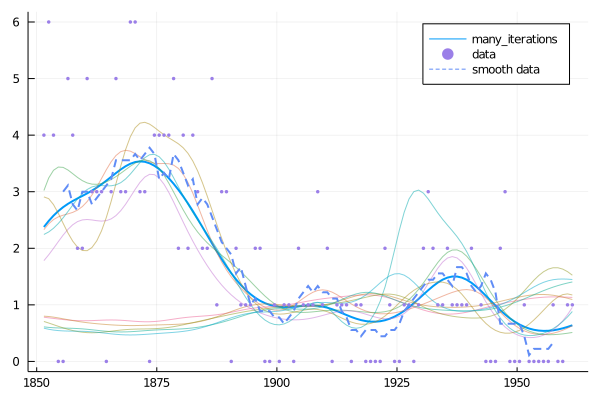

In [44]:
plot()
plot_mean(next_iteration.result, "many_iterations")
plot_mgvi_samples(next_iteration)
plot_data()

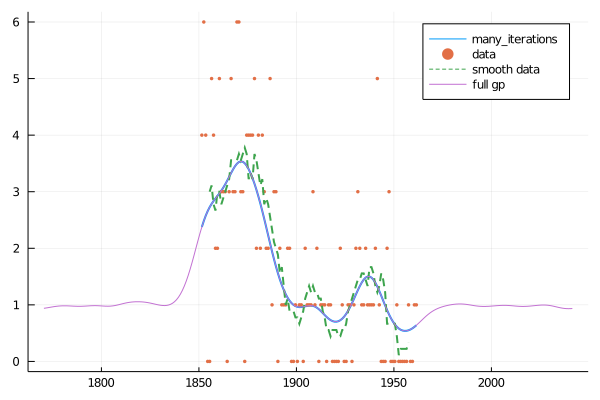

In [45]:
plot()
plot_mean(next_iteration.result, "many_iterations")
plot_data()
plot_full_gp(next_iteration.result)

### Maximum a posteriori estimation (MAP)

In [46]:
max_posterior = Optim.optimize(x -> -logpdf(model(x), data) + (x'*x)/2, starting_point, LBFGS(), Optim.Options(show_trace=VERBOSE, g_tol=1E-10, iterations=300));

if VERBOSE
    display(max_posterior)
end

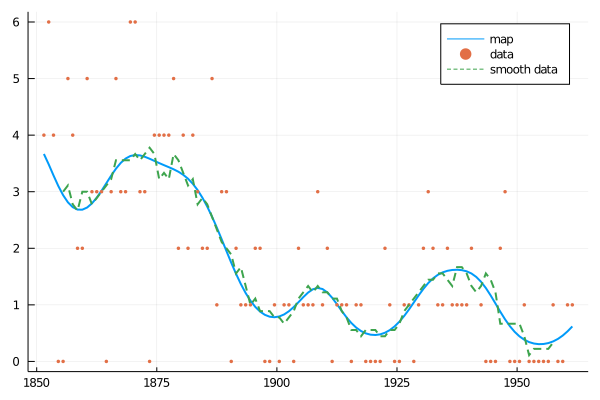

In [47]:
plot()
plot_mean(Optim.minimizer(max_posterior), "map")
plot_data()

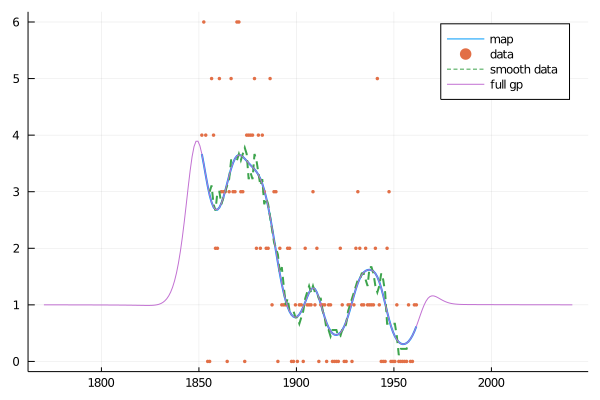

In [48]:
plot()
plot_mean(Optim.minimizer(max_posterior), "map")
plot_data()
plot_full_gp(Optim.minimizer(max_posterior))